In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [2]:
%matplotlib inline

In [3]:
! ls zippedData

bom.movie_gross.csv.gz
im.db
im.db.zip
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


### Saving each non-SQL file as a DataFrame

In [4]:
gross_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [5]:
info_rt = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')

In [6]:
reviews_rt = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')

In [7]:
movies_tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [8]:
budgets_tn = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### Exloring the SQL database for IMDb

In [9]:
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip, path='ZippedData')

In [10]:
# Created a new file called im.db
# CAREFUL because this file is too big to push to GitHub...

In [11]:
con = sqlite3.connect('zippedData/im.db')

In [12]:
pd.read_sql("""
SELECT *
FROM sqlite_schema
WHERE type='table'
""", con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


### Merging the IMDb `movie_basics` and `movie_ratings` files

In [13]:
imdb_movies_plus_ratings = pd.read_sql("""
SELECT * FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
""" , con)

In [14]:
# Preivew the resulting DataFrame
imdb_movies_plus_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [15]:
imdb_movies_plus_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 8.9+ MB


In [16]:
imdb_movies_plus_ratings.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
averagerating      72288
numvotes           72288
dtype: int64

In [17]:
imdb_movies_plus_ratings.isna().sum()/len(imdb_movies_plus_ratings)

movie_id           0.000000
primary_title      0.000000
original_title     0.000144
start_year         0.000000
runtime_minutes    0.217176
genres             0.037005
averagerating      0.494635
numvotes           0.494635
dtype: float64

### There are several columns with null data to contend with.
Let's start with the `averagerating` and `numvotes` columns.

In [18]:
imdb_movies_plus_ratings.isna()['averagerating'].equals(imdb_movies_plus_ratings.isna()['numvotes'])

True

**These two columns are are null in all the same rows.**

**Below, we view a sample of the titles where there are no ratings or votes.**

They appear to be mostly niche titles, many with a runtime under one hour. They are not likely to be representative of the content Microsoft wants to promote as it debuts its streaming service. Perhaps we can drop these titles.

### Below, we view a sample of the titles where there are no ratings or votes.

They appear to be mostly niche titles, many with missing runtimes under one hour or runtimes under one hour. They are not representative of the content Microsoft wants to promote as it debuts its streaming service.

Although they make up about half the dataset, we are not likely to derive any meaningful insight from these titles. Keeping them would disrupt our analysis and there's no value we can replace them with. For these reasons we'll drop these rows. Fortunately, our dataset will still have about 70,000 entries to work with.

In [19]:
NaN_imdb_movies_plus_ratings = imdb_movies_plus_ratings[
    imdb_movies_plus_ratings['numvotes'].isna()]

In [20]:
NaN_imdb_movies_plus_ratings.sample(20)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
122612,tt7418180,Happy Suicide,Happy Suicide,2020,98.0,Thriller,NaN,NaN
138625,tt8924840,Africa's Super Snake,Africa's Super Snake,2017,50.0,Documentary,NaN,NaN
133746,tt8396756,Agosto Final,Agosto Final,2016,NaN,Documentary,NaN,NaN
95650,tt5581616,Under the Sun,Under the Sun,2016,95.0,Drama,NaN,NaN
3152,tt10314454,Mr. Bleachers,Mr. Bleachers,2020,NaN,"Comedy,Horror",NaN,NaN
106369,tt6223320,Honey Pie,Honey Pie,2017,NaN,"Comedy,Drama",NaN,NaN
127094,tt7775890,Les Lions de Cannes 2015: Le meilleur de la pub,Les Lions de Cannes 2015: Le meilleur de la pub,2015,90.0,None,NaN,NaN
107643,tt6311852,The High Life: Slim Aarons,The High Life: Slim Aarons,2016,NaN,None,NaN,NaN
47334,tt2807992,Banking with Life,Banking with Life,2013,50.0,"Documentary,News",NaN,NaN
66691,tt3799050,Was Wir Nicht Sehen,Was Wir Nicht Sehen,2014,78.0,"Documentary,Drama",NaN,NaN


In [21]:
# Dropping titles with no votes or rating

imdb_movies_plus_ratings.dropna(subset=['numvotes'], inplace=True)

In [22]:
# confirming that this worked for both the numvotes and averagerating columns:

print(imdb_movies_plus_ratings['averagerating'].isnull().sum())
print(imdb_movies_plus_ratings['numvotes'].isnull().sum())

0
0


In [23]:
# Reminding myself of the basic info in the dataset 
imdb_movies_plus_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 146134
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 5.1+ MB


In [24]:
imdb_movies_plus_ratings.isna().sum()/len(imdb_movies_plus_ratings)

movie_id           0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
runtime_minutes    0.103174
genres             0.010886
averagerating      0.000000
numvotes           0.000000
dtype: float64

**In the remaining dataset, about 1 percent of the titles are missing genres. Since genres are going to be central to our recommendations, we'll drop those rows, too.**

In [25]:
imdb_movies_plus_ratings.dropna(subset=['genres'], inplace=True)

### Checking if there are any duplicate titles.

In [26]:
imdb_movies_plus_ratings.duplicated(subset='original_title').sum()

2707

**There are bound to be tons of movies with the same name out there.**

**Let's see if there are movies with the same name, runtime, and year.**

In [27]:
imdb_movies_plus_ratings[
    imdb_movies_plus_ratings.duplicated(
        subset=[
            'original_title', 'runtime_minutes', 'start_year'])]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
2658,tt10275936,Raggarjävlar (Swedish Greasers),Raggarjävlar (Swedish Greasers),2019,70.0,Documentary,6.9,47.0
11830,tt1644694,The Gift,The Gift,2010,NaN,"Animation,Drama",5.9,7.0
12984,tt1674217,Transit,Transit,2010,80.0,"Biography,Documentary,Family",6.7,13.0
19111,tt1825978,The Artist,The Artist,2011,100.0,Thriller,6.8,6.0
23887,tt1967651,Unconditional Love,Unconditional,2012,92.0,"Drama,Thriller",5.6,660.0
24139,tt1977822,Inside,Inside,2012,85.0,Horror,4.0,397.0
33380,tt2246595,Blood Money,Blood Money,2012,109.0,"Action,Drama,Thriller",5.2,881.0
37698,tt2363471,The Summit,The Summit,2012,95.0,"Adventure,Documentary",6.9,4147.0
47280,tt2805202,Rise of the Undead,Rise of the Undead,2013,70.0,Action,4.2,20.0
50941,tt3019098,The Last Act,The Last Act,2012,NaN,Thriller,5.7,6.0


**We should delete the duplicates, but we should keep the version with the higher vote count.**

In [28]:
imdb_movies_plus_ratings.sort_values(by='numvotes', ascending=False, inplace=True)

In [29]:
imdb_movies_plus_ratings.drop_duplicates(subset=[
            'original_title', 'runtime_minutes', 'start_year'], inplace=True, keep='first')

In [30]:
imdb_movies_plus_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334.0
20342,tt1853728,Django Unchained,Django Unchained,2012,165.0,"Drama,Western",8.4,1211405.0
356,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655.0


**The values in the genres column contain multiple genres separated by a comma. I'll need to separate them somehow.**

In [31]:
# pd.explode()

In [32]:
clean_genres = imdb_movies_plus_ratings.copy()

In [33]:
clean_genres['genres'] = clean_genres['genres'].str.split(',')

In [34]:
clean_genres.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"[Action, Adventure, Sci-Fi]",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"[Action, Thriller]",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"[Adventure, Drama, Sci-Fi]",8.6,1299334.0


In [35]:
# Creating a list of all unique genres.
genres_all = set()
genres_col = clean_genres['genres']

for glist in genres_col:
    for g in glist:
        genres_all.add(g)

In [36]:
print(f'There are {len(genres_all)} genres on IMDb. They are:\n\n {genres_all}.')

There are 26 genres on IMDb. They are:

 {'Adventure', 'News', 'Music', 'Documentary', 'Horror', 'Mystery', 'Adult', 'War', 'Comedy', 'Musical', 'Game-Show', 'Short', 'Western', 'Sport', 'Crime', 'Action', 'Reality-TV', 'Biography', 'Family', 'Fantasy', 'Animation', 'Sci-Fi', 'History', 'Thriller', 'Romance', 'Drama'}.


**Creating a new dataset where the genres are separated**

In [37]:
expl_clean_genres = clean_genres.explode('genres')

In [38]:
expl_clean_genres.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,Action,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Adventure,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Sci-Fi,8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Action,8.4,1387769.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Thriller,8.4,1387769.0


In [39]:
expl_clean_genres['genres'].value_counts()

Drama          30784
Documentary    17748
Comedy         17289
Thriller        8212
Horror          7672
Action          6986
Romance         6586
Crime           4610
Adventure       3817
Biography       3807
Family          3411
Mystery         3038
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1967
Animation       1742
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genres, dtype: int64

**Removing titles in genres that seem to be causing noise**

In [40]:
titles_in_noisy_genres = (
    expl_clean_genres[
        expl_clean_genres['genres'].isin(
            ['Game-Show', 'Short', 'Adult','Reality-TV'])]['movie_id'])

In [41]:
titles_in_noisy_genres

27896     tt2088950
9550      tt1563778
65025     tt3718824
61186     tt3531586
91201     tt5275236
74791     tt4268970
27299     tt2076157
84219     tt4870190
115445    tt6848590
57191     tt3334122
48072     tt2853636
97663     tt5703108
91194     tt5274440
83265     tt4807744
118853    tt7128608
139971    tt9060598
128093    tt7867026
54420     tt3201538
48640     tt2896176
58407     tt3402720
9275      tt1548927
111410    tt6511076
130182    tt8053430
Name: movie_id, dtype: object

In [42]:
# model
# clean_genres.drop(index=clean_genres[clean_genres['movie_id'].isin(titles_in_noisy_genres)].index)

In [43]:
for dataset in [clean_genres, expl_clean_genres, imdb_movies_plus_ratings]:
    dataset = dataset.drop(index=dataset[dataset['movie_id'].isin(titles_in_noisy_genres)].index)

In [44]:
# Group by genres and -- 
# Bar charts of the average rating and numvotes?
# 

In [45]:
###################################
###################################

## Measuring Success

I plan to use rating and number of votes as indicators of success. In the streaming age, these metrics are are arguably better indicators of a movie's popularity (and therefore incentive to subscribe to streaming service) as opposed to box office revenue and ROI.

Below, I start to explore the relationship between `averagerating` and `numvotes`.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

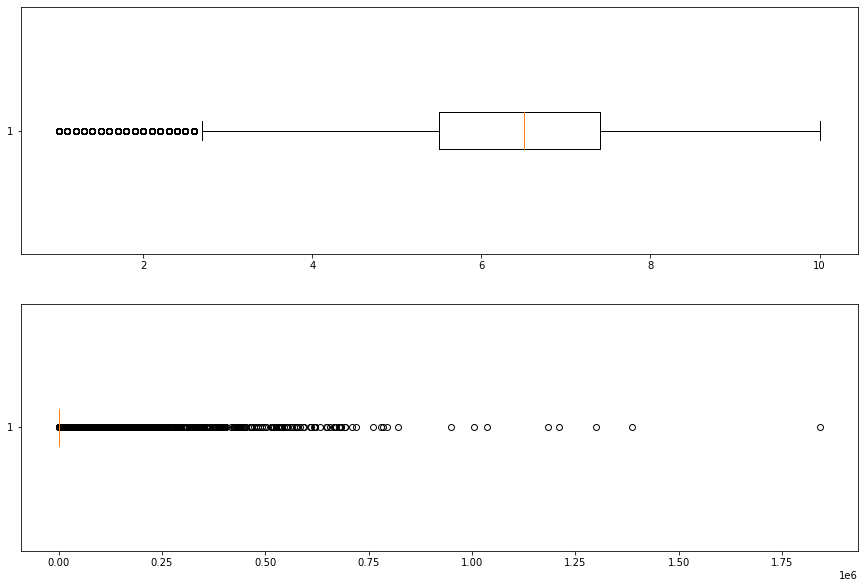

In [46]:
fig, (ax_rating, ax_votes) = plt.subplots(nrows=2, figsize=(15,10))

ax_rating.boxplot(imdb_movies_plus_ratings['averagerating'], vert=False)
ax_votes.boxplot(imdb_movies_plus_ratings['numvotes'], vert=False)
plt.tight_layout

<AxesSubplot:xlabel='averagerating', ylabel='numvotes'>

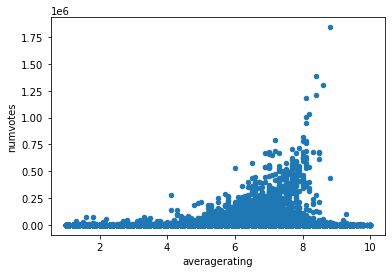

In [47]:
imdb_movies_plus_ratings.plot(kind='scatter', y='numvotes', x='averagerating')